In [35]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from numpy import linalg as LA
from numpy.linalg import inv

# Data processing

In [36]:
# chose 25 folders randomly
chosen = np.random.default_rng(2022).choice(np.arange(1, 68 + 1), 25, replace=False)

# Load images 
images = []
labels = []

directory = Path("/Python_programme/Jupyter/PIE_origin")
for i in chosen:
    # split train and test
    sub_images = []
    sub_labels = []
    sub_directory = directory / str(i)
    
    files = list(sub_directory.glob("*.jpg"))
    np.random.default_rng(2023).shuffle(files)
    for filename in files:
        im = Image.open(filename)
        sub_images.append(np.array(im))
        sub_labels.append(i)  # Use folder numbers as labels
    images.append(sub_images)
    labels.append(sub_labels)
    
# len(images)
# len(labels)

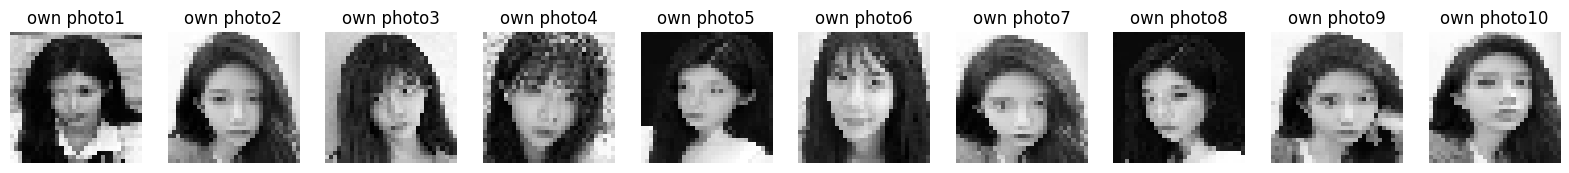

In [37]:
# process own photos
own_imgs= []
own_labels = []

for i in range(1, 11):
    img = cv2.imread('/Python_programme/Jupyter/own_photos/'+ str(i)+'.jpg', cv2.IMREAD_GRAYSCALE)  # convert to gray image
    img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_CUBIC)
    own_imgs.append(img)   # create imgs in desired format
    own_labels.append(69)  # label own photos as class 69
    
# split training and testing data sets 
own_train_imgs = own_imgs[0:7]      # first 7 phots for training
own_test_imgs = own_imgs[7:]        # last 3 photos for testing
own_train_labels = own_labels[0:7]  
own_test_labels = own_labels[7:]

# visualize photos
fig = plt.figure(figsize = (20,10))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(own_imgs[i-1], cmap = 'gray' )
    plt.title('own photo'+ str(i))
    plt.axis('off')
    
plt.show()

In [38]:
# Train-test split
NUM_TRAIN_IMAGES_PER_SUBJECT = np.int_(np.around(0.7 * 170))

images_train, images_test = np.split(np.array(images), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
labels_train, labels_test = np.split(np.array(labels), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
own_images_train, own_images_test = np.split(np.array(own_imgs), [7])
own_labels_train, own_labels_test = np.split(np.array(own_labels), [7])

import warnings
warnings.filterwarnings('ignore', category=Warning)

# Flatterning
PIE_images_train = images_train.reshape(25*NUM_TRAIN_IMAGES_PER_SUBJECT, 1024)
own_images_train = own_images_train.reshape(7, 1024)
images_test = images_test.reshape(25*(170-NUM_TRAIN_IMAGES_PER_SUBJECT), 1024)
own_images_test = own_images_test.reshape(3, 1024)

labels_train = labels_train.reshape(25*NUM_TRAIN_IMAGES_PER_SUBJECT)
labels_test = labels_test.reshape(25*(170-NUM_TRAIN_IMAGES_PER_SUBJECT))

# Combine PIE images and own photos to get full train and test sets
full_train_set = np.append(PIE_images_train,own_images_train,axis=0,)
full_train_labels = np.append(labels_train, own_labels_train)

full_test_set = np.append(images_test,own_images_test,axis=0,)
full_test_labels = np.append(labels_test, own_labels_test)

# LDA

In [39]:
X_train = full_train_set
y_train = full_train_labels

## 1. reduce data dimensionality from to 2, 3 and visualize

In [40]:
# compute withiin label S
ulabels = np.unique(y_train)
feature_means = np.zeros((len(ulabels), 1024))

within_label_s = np.zeros((1024, 1024))

for i in range(len(ulabels)):
    label = ulabels[i]
    label_samples = X_train[y_train == label]  # get sample with current label
    feature_means[i] = np.mean(label_samples, axis=0)  # mean of features for current label

    s = np.zeros_like(within_label_s)
    for label_sample in label_samples:
        s += np.outer((label_sample - feature_means[i]),(label_sample - feature_means[i]),)

    within_label_s += s

# compute between label S
means = np.mean(X_train, axis=0)
between_label_s = np.zeros_like(within_label_s)

for i in range(len(ulabels)):
    label = ulabels[i]
    n = np.count_nonzero(y_train == label)  # number of samples with current label
    between_label_s += n * np.outer((feature_means[i] - means),(feature_means[i] - means),)

eigvals, eigvecs = LA.eig(inv(within_label_s) @ between_label_s)

order = np.argsort(-eigvals)  
eigvals = eigvals[order]
eigvecs = eigvecs[:, order].real  

# Projection
X_lda = X_train @ eigvecs[:, :9]

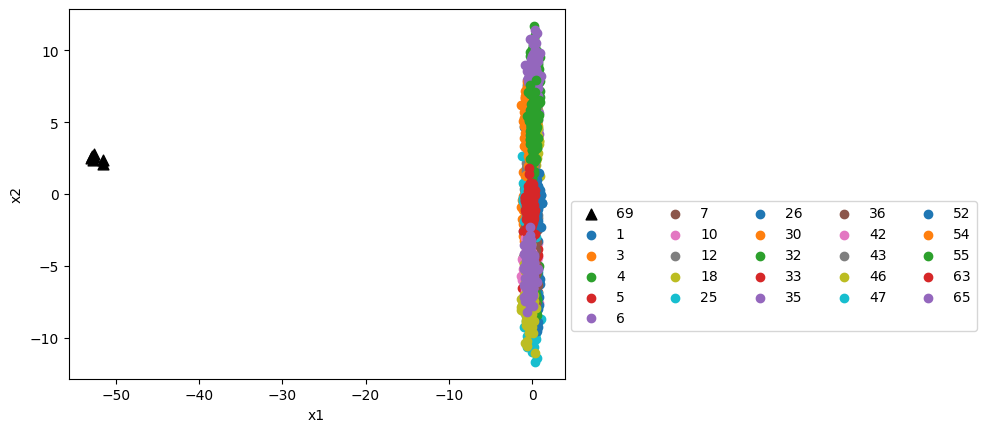

In [41]:
# 2D
fig = plt.figure()
ax = fig.add_subplot()

# highlight point of own photos in dark triangle_up marker
ax.scatter(X_lda[y_train == 69][:, 0],X_lda[y_train == 69][:, 1],marker="^", label=69,c="k",s=60)
# show points for figures in PIE
for i in np.unique(y_train[y_train != 69]):
    ax.scatter(X_lda[y_train == i][:, 0],X_lda[y_train == i][:, 1],label=i,)

ax.set_xlabel("x1")
ax.set_ylabel("x2")
lgd = ax.legend(ncol=np.int_(25 / 5), bbox_to_anchor=(1, 0.5))

plt.show()

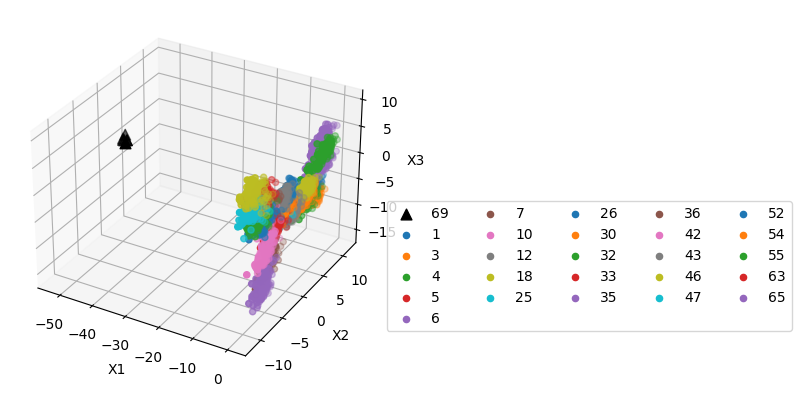

In [42]:
# 3D
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# highlight point of own photos in dark triangle_up marker
ax.scatter(X_lda[y_train == 69][:, 0],X_lda[y_train == 69][:, 1],X_lda[y_train == 69][:, 2],
           marker="^",label=69,c="k",s=60,)
for i in np.unique(y_train[y_train != 69]):
    ax.scatter(X_lda[y_train == i][:, 0],X_lda[y_train == i][:, 1],X_lda[y_train == i][:, 2],label=i,)

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")
lgd = ax.legend(ncol=np.int_(25 / 5), bbox_to_anchor=(1, 0.5))

plt.show()

## 2. reduce the dimension to 2, 3, 9 and do classification

In [43]:
X_lda_test = images_test @ eigvecs[:, :9]
own_X_lda_test = own_images_test @ eigvecs[:, :9]

def NN_classification(dim, X, y):
    dist_arr_test = LA.norm(X[:, :dim][:, np.newaxis] - X_lda[:, :dim], axis=2)
    dist_arr_test = np.argsort(dist_arr_test)  

    k = 1  
    knn_indices = dist_arr_test[:, :k]
    knn_labels = y_train[knn_indices]

    result = knn_labels[:, 0]
    acc = np.sum(result == y) / y.size

    return acc


def Accuracy(X, y):
    for i in [2, 3, 9]:
        print("Accuracy with dim",i,"=",NN_classification(i, X, y),)

print("For PIE:")
Accuracy(X_lda_test, labels_test)
print("For own photos:")
Accuracy(own_X_lda_test, own_labels_test)

For PIE:
Accuracy with dim 2 = 0.16941176470588235
Accuracy with dim 3 = 0.38509803921568625
Accuracy with dim 9 = 0.9058823529411765
For own photos:
Accuracy with dim 2 = 0.0
Accuracy with dim 3 = 0.0
Accuracy with dim 9 = 0.0
